In [6]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F

In [7]:
batch_size = 8
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='G:/dataset/', train=True, download=False, transform=transform)  
test_dataset = datasets.MNIST(root='G:/dataset/', train=False, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

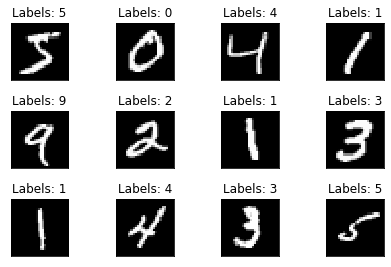

In [8]:
fig = plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.imshow(train_dataset.train_data[i], cmap='gray', interpolation='none')
    plt.title("Labels: {}".format(train_dataset.train_labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [9]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Sequential(          #input shape 28*28
            torch.nn.Conv2d(1, 10, kernel_size=5), #out: 10 * 24 * 24 
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),  #out: 10 * 12 * 12
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(10, 20, kernel_size=5), #out: 20 * 8 * 8
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), #out: 20 * 4 * 4 = 320
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(320, 50),
            torch.nn.Linear(50, 10),
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)  # 一层卷积层,一层池化层,一层激活层(图是先卷积后激活再池化，差别不大)
        x = self.conv2(x)  # 再来一次
        x = x.view(batch_size, -1)  # flatten 变成全连接网络需要的输入 (batch, 20,4,4) ==> (batch,320), -1 此处自动算出的是320
        x = self.fc(x)
        return x  # 最后输出的是维度为10的，也就是（对应数学符号的0~9）


In [10]:
learning_rate = 0.008 
momentum = 0.02
model = Net()
criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)  # lr学习率，momentum冲量

In [11]:
def train(epoch):
    running_loss = 0.0  # 这整个epoch的loss清零
    running_total = 0
    running_correct = 0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        optimizer.zero_grad()

        # forward + backward + update
        outputs = model(inputs)
        loss = criterion(outputs, target)

        loss.backward()
        optimizer.step()

        # 把运行中的loss累加起来，为了下面300次一除
        running_loss += loss.item()
        # 把运行中的准确率acc算出来
        _, predicted = torch.max(outputs.data, dim=1)
        running_total += inputs.shape[0]
        running_correct += (predicted == target).sum().item()

        if batch_idx % 300 == 299:  # 不想要每一次都出loss，浪费时间，选择每300次出一个平均损失,和准确率
            print('[%d, %5d]: loss: %.3f , acc: %.2f %%'
                  % (epoch + 1, batch_idx + 1, running_loss / 300, 100 * running_correct / running_total))
            running_loss = 0.0  # 这小批300的loss清零
            running_total = 0
            running_correct = 0  # 这小批300的acc清零

In [12]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():  # 测试集不用算梯度
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)  # dim = 1 列是第0个维度，行是第1个维度，沿着行(第1个维度)去找1.最大值和2.最大值的下标
            total += labels.size(0)  # 张量之间的比较运算
            correct += (predicted == labels).sum().item()
    acc = correct / total
    print(100 * acc)  # 求测试的准确率，正确数/总数
    return acc

In [13]:
# super parameters
EPOCH = 2

[1,   300]: loss: 1.455 , acc: 54.83 %
[1,   600]: loss: 0.459 , acc: 85.21 %
[1,   900]: loss: 0.305 , acc: 91.17 %
[1,  1200]: loss: 0.257 , acc: 91.96 %
[1,  1500]: loss: 0.210 , acc: 93.46 %
[1,  1800]: loss: 0.170 , acc: 94.83 %
[1,  2100]: loss: 0.155 , acc: 95.00 %
[1,  2400]: loss: 0.162 , acc: 95.38 %
[1,  2700]: loss: 0.145 , acc: 95.71 %
[1,  3000]: loss: 0.123 , acc: 96.29 %
[1,  3300]: loss: 0.129 , acc: 96.33 %
[1,  3600]: loss: 0.103 , acc: 97.00 %
[1,  3900]: loss: 0.136 , acc: 95.92 %
[1,  4200]: loss: 0.127 , acc: 95.58 %
[1,  4500]: loss: 0.089 , acc: 97.50 %
[1,  4800]: loss: 0.112 , acc: 96.54 %
[1,  5100]: loss: 0.090 , acc: 97.08 %
[1,  5400]: loss: 0.117 , acc: 96.33 %
[1,  5700]: loss: 0.092 , acc: 97.17 %
[1,  6000]: loss: 0.103 , acc: 96.67 %
[1,  6300]: loss: 0.091 , acc: 97.42 %
[1,  6600]: loss: 0.081 , acc: 97.50 %
[1,  6900]: loss: 0.084 , acc: 97.38 %
[1,  7200]: loss: 0.089 , acc: 97.29 %
[1,  7500]: loss: 0.086 , acc: 97.25 %
97.75
[2,   300]: loss: 0

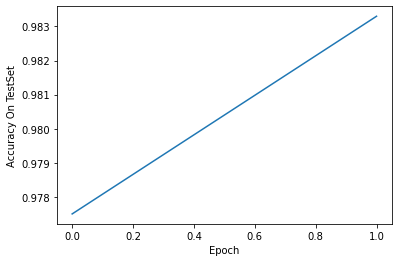

In [14]:
if __name__ == '__main__':
    acc_list_test = []
    for epoch in range(EPOCH):
        train(epoch)
        # if epoch % 10 == 9:  #每训练10轮 测试1次
        acc_test = test()
        acc_list_test.append(acc_test)

    plt.plot(acc_list_test)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy On TestSet')
    plt.show()